In [454]:
# Example snippets for posterity
# g_index

# g.columns
# g[["source_val_label_accuracy", "target_val_label_accuracy", "total_experiment_time_secs"]]
# g.columns
# g.index

# Grouping by parameters (minus seed) gives us the individual experiments as the groups
# p_group = p.groupby(parameter_columns_minus_seed)

# Can set a multi-index as well
# p_index = p.set_index(parameter_columns_minus_seed)
# p_index

# p["experiment_name"]

# Gett the max of each group
# idx = ["target_val_label_accuracy"].transform(max) == p["target_val_label_accuracy"]

# p_group.count()


# p[idx]

In [455]:
import pandas as pd
import seaborn as sb
import json
import os
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib
import copy



from steves_utils.summary_utils import (
    get_experiments_from_path
)

from steves_utils.utils_v2 import (
    get_experiments_base_path
)

In [456]:
PTN_SERIES = [
    "tuned_1v2",
    "baseline_ptn_32bit",
    "baseline_ptn",
    # "tl_3",
    # "tl_1",

    "hyperparameters_3",
    # "cnn_2",
    # "cnn_3",
    "tuned_1",
    # "cnn_1",
    "hyperparameters_2",
    "hyperparameters_1",


    # "tl_2",
]

CNN_SERIES = [

]

TL_SERIES = [
    # "tl_2v2",
    # "tl_3v2",
    "tl_1v2",
]
def get_tl_trials(experiments_to_get=TL_SERIES):
    all_trials = []

    for experiment in experiments_to_get:
        trials = get_experiments_from_path(
            os.path.join(get_experiments_base_path(), experiment)
        )

        for t in trials:
            t["series_name"] = experiment
            for key, value in t["parameters"].items():
                t[key] = value
            del t["parameters"]

            for key, value in t["results"].items():
                t[key] = value
            del t["results"]

            for key, value in t.items():
                if type(value) == list:
                    t[key] = tuple(value)
        
        all_trials.extend(
            trials
        )

    return all_trials

In [457]:
tl = get_tl_trials()
tl = pd.DataFrame(tl)
tl = tl.drop(columns=["domains_source", "domains_target"]) # These are bogus parameters I've injected in trial notebooks
tl.columns

Index(['experiment_name', 'history', 'dataset_metrics', 'series_name',
       'device', 'lr', 'n_shot', 'n_query', 'train_k_factor', 'val_k_factor',
       'test_k_factor', 'torch_default_dtype', 'n_epoch', 'patience',
       'criteria_for_best', 'x_net', 'NUM_LOGS_PER_EPOCH', 'BEST_MODEL_PATH',
       'n_way', 'datasets', 'dataset_seed', 'seed', 'x_shape',
       'source_test_label_accuracy', 'source_test_label_loss',
       'target_test_label_accuracy', 'target_test_label_loss',
       'source_val_label_accuracy', 'source_val_label_loss',
       'target_val_label_accuracy', 'target_val_label_loss',
       'total_epochs_trained', 'total_experiment_time_secs', 'confusion',
       'per_domain_accuracy'],
      dtype='object')

In [458]:
result_columns = [
    'source_test_label_accuracy',
    'source_test_label_loss',
    'target_test_label_accuracy',
    'target_test_label_loss',
    'source_val_label_accuracy',
    'source_val_label_loss',
    'target_val_label_accuracy',
    'target_val_label_loss',
    'total_experiment_time_secs',
    'per_domain_accuracy',
    'history',
    'total_epochs_trained'
    'confusion'    
]
parameter_columns_minus_seed = [
    'device'
    'lr'
    'n_shot'
    'n_query'
    'train_k_factor'
    'val_k_factor'
    'test_k_factor'
    'torch_default_dtype'
    'n_epoch'
    'patience'
    'criteria_for_best'
    'n_way'
    'datasets'
    'x_shape'
]

eh_columns = [
    'dataset_metrics',
    'x_net',
    'experiment_name',
    'series_name',
    'dataset_seed',
    'seed',
    'NUM_LOGS_PER_EPOCH'
    'BEST_MODEL_PATH'
]

In [459]:
def set_nice_sb_style():
    matplotlib.rcParams.update({'font.size': 22})
    plt.style.use('seaborn-whitegrid')

def add_value_to_sb_bars(fg):
    # iterate through axes
    for ax in fg.axes.ravel():
        
        ax.tick_params(labelbottom=True)
        
        # add annotations
        for c in ax.containers:
            labels = [f'{(v.get_height()):.2f}' for v in c]
            ax.bar_label(c, labels=labels, label_type='edge')
        ax.margins(y=0.2)

def add_x_val_to_sb_bars(fg):
    # iterate through axes
    for ax in fg.axes.ravel():
        
        ax.tick_params(labelbottom=True)
        
        # add annotations
        for c in ax.containers:
            labels = [f'{(v.get_height()):.2f}' for v in c]
            ax.bar_label(c, labels=labels, label_type='edge')
        ax.margins(y=0.2)

In [460]:
independent_vars = ["source_name", "target_name", "x_transform"]
def get_tl_1():
    tl = get_tl_trials()
    tl = pd.DataFrame(tl)
    tl = tl.drop(columns=["domains_source", "domains_target"]) # These are bogus parameters I've injected in trial notebooks
    tl.columns

    # Get the trials only from the series we want
    p = tl[tl["series_name"].isin(["tl_1v2"])]
    p = p.reset_index(drop=True)
    # Drop columns we aren't interested in (They clutter up the view)
    # p = p.drop(columns=[
    #     "experiment_name",
    #     "series_name",
    #     "history",
    #     "source_test_label_loss",
    #     "target_test_label_loss",
    #     "source_val_label_loss",
    #     "target_val_label_loss",
    #     "confusion",
    #     "per_domain_accuracy",
    #     "NUM_LOGS_PER_EPOCH",
    #     "BEST_MODEL_PATH",
    # ])

    pickle_name_mapping = {
        "cores.stratified_ds.2022A.pkl": "cores",
        "metehan.stratified_ds.2022A.pkl": "metehan",
        "oracle.Run1_10kExamples_stratified_ds.2022A.pkl": "oracle.run1",
        "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl": "oracle.run1.framed",
        "oracle.Run2_10kExamples_stratified_ds.2022A.pkl": "oracle.run2",
        "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl": "oracle.run2.framed",
        "wisig.node3-19.stratified_ds.2022A.pkl": "wisig",
    }

    """
    This requires some knowledge of how the series was structured
    For instance, we know that if original oracle was used, but not the max amount of 
    items then it should be called oracle.*.limited

    We also know that the x_transforms are the same between source and target
    """
    def datasets_to_columns(datasets):
        assert len(datasets) == 2

        if datasets[0]["source_or_target_dataset"] == "source":
            source = datasets[0]
            target = datasets[1]
        else:
            target = datasets[0]
            source = datasets[1]
        
        source_name = os.path.basename(source["pickle_path"])
        target_name = os.path.basename(target["pickle_path"])
        
        source_name = pickle_name_mapping[source_name]
        target_name = pickle_name_mapping[target_name]

        if source_name in ["oracle.run1", "oracle.run2"]:
            if source["num_examples_per_domain_per_label"] not in [-1, 10000]:
                assert source["num_examples_per_domain_per_label"] == 2000
                source_name = source_name+".limited"

        if target_name in ["oracle.run1", "oracle.run2"]:
            if target["num_examples_per_domain_per_label"] not in [-1, 10000]:
                assert target["num_examples_per_domain_per_label"] == 2000
                target_name = target_name+".limited"


        assert source["x_transforms"] == target["x_transforms"]
        transforms = source["x_transforms"]
        assert len(transforms) == 1 or len(transforms) == 0

        if len(transforms) == 0:
            transforms = "None"
        else:
            transforms = str(transforms[0])

        return source_name, target_name, transforms

    # p["datasets"] = p.apply(lambda row : str(row["datasets"]), axis=1)
    p[["source_name", "target_name", "x_transform"]] = [datasets_to_columns(r["datasets"]) for i,r in p.iterrows()]

    # Ensure that the indpendent vars are the only variables that are changing between trials
    control_vars = list(set(parameter_columns_minus_seed) - set(independent_vars+["seed", "dataset_seed"]))
    for i, size in p.groupby(independent_vars+["seed", "dataset_seed"]).size().iteritems():
        assert size == 1

    p["Transfer"] = p.apply(lambda row : str(row["source_name"]) + "->" + str(row["target_name"]), axis=1)
    p = p.rename(columns={"source_val_label_accuracy": "Source Val Accuracy", "target_val_label_accuracy": "Target Val Accuracy"})
    
    return p
    
get_tl_1()

,experiment_name,history,dataset_metrics,series_name,device,lr,n_shot,n_query,train_k_factor,val_k_factor,...,Target Val Accuracy,target_val_label_loss,total_epochs_trained,total_experiment_time_secs,confusion,per_domain_accuracy,source_name,target_name,x_transform,Transfer
0,tl_1v2:cores-oracle.run1.framed,"{'epoch_indices': [1, 2, 3, 4, 5, 6, 7, 8, 9, ...","{'source': {'train': {'n_unique_x': 179200, 'n...",tl_1v2,cuda,0.0001,3,2,3,2,...,0.852939,0.952790,10,2437.278476,"{'ORACLE.run1_8': {'13': {'10': 28, '13': 150,...","{'ORACLE.run1_8': {'accuracy': 0.90546875, 'so...",oracle.run1.framed,cores,unit_mag,oracle.run1.framed->cores
1,tl_1v2:cores-oracle.run1.framed,"{'epoch_indices': [1, 2, 3, 4, 5, 6, 7], 'trai...","{'source': {'train': {'n_unique_x': 179200, 'n...",tl_1v2,cuda,0.0001,3,2,3,2,...,0.934964,4.748477,7,1799.926603,"{'ORACLE.run1_26': {'0': {'0': 177, '14': 22, ...","{'ORACLE.run1_26': {'accuracy': 0.878125, 'sou...",oracle.run1.framed,cores,None,oracle.run1.framed->cores
2,tl_1v2:cores-oracle.run1.framed,"{'epoch_indices': [1, 2, 3, 4, 5, 6, 7], 'trai...","{'source': {'train': {'n_unique_x': 175189, 'n...",tl_1v2,cuda,0.0001,3,2,3,2,...,0.291536,2.137561,7,1553.974931,"{'CORES_3': {'43': {'43': 128}, '9': {'9': 150...","{'CORES_3': {'accuracy': 0.9994549418604651, '...",cores,oracle.run1.framed,unit_power,cores->oracle.run1.framed
3,tl_1v2:cores-oracle.run1.framed,"{'epoch_indices': [1, 2, 3, 4, 5, 6, 7], 'trai...","{'source': {'train': {'n_unique_x': 175174, 'n...",tl_1v2,cuda,0.0001,3,2,3,2,...,0.271810,2.357094,7,1752.598162,"{'CORES_4': {'42': {'42': 32}, '0': {'0': 80},...","{'CORES_4': {'accuracy': 0.9973802395209581, '...",cores,oracle.run1.framed,unit_mag,cores->oracle.run1.framed
4,tl_1v2:cores-oracle.run1.framed,"{'epoch_indices': [1, 2, 3, 4, 5], 'train_labe...","{'source': {'train': {'n_unique_x': 175169, 'n...",tl_1v2,cuda,0.0001,3,2,3,2,...,0.563867,1.842452,5,1163.337423,"{'CORES_4': {'38': {'38': 40}, '3': {'3': 124}...","{'CORES_4': {'accuracy': 0.9979166666666667, '...",cores,oracle.run1.framed,None,cores->oracle.run1.framed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,tl_1v2:cores-oracle.run1,"{'epoch_indices': [1, 2, 3, 4, 5, 6, 7, 8, 9, ...","{'source': {'train': {'n_unique_x': 175211, 'n...",tl_1v2,cuda,0.0001,3,2,3,2,...,0.171784,4.858982,13,3451.827425,"{'CORES_4': {'38': {'38': 40}, '3': {'3': 123,...","{'CORES_4': {'accuracy': 0.9994318181818181, '...",cores,oracle.run1,unit_power,cores->oracle.run1
251,tl_1v2:cores-oracle.run1,"{'epoch_indices': [1, 2, 3, 4, 5, 6, 7, 8, 9, ...","{'source': {'train': {'n_unique_x': 175222, 'n...",tl_1v2,cuda,0.0001,3,2,3,2,...,0.175514,3.844009,10,2701.497276,"{'CORES_2': {'21': {'21': 120}, '4': {'4': 130...","{'CORES_2': {'accuracy': 1.0, 'source?': True}...",cores,oracle.run1,unit_power,cores->oracle.run1
252,tl_1v2:cores-oracle.run1,"{'epoch_indices': [1, 2, 3, 4, 5], 'train_labe...","{'source': {'train': {'n_unique_x': 175213, 'n...",tl_1v2,cuda,0.0001,3,2,3,2,...,0.387266,1.951725,5,944.919991,"{'CORES_2': {'21': {'21': 120}, '4': {'4': 130...","{'CORES_2': {'accuracy': 0.9985795454545454, '...",cores,oracle.run1,None,cores->oracle.run1
253,tl_1v2:cores-oracle.run1,"{'epoch_indices': [1, 2, 3, 4, 5, 6, 7, 8, 9],...","{'source': {'train': {'n_unique_x': 175193, 'n...",tl_1v2,cuda,0.0001,3,2,3,2,...,0.161302,3.595981,9,2493.182095,"{'CORES_4': {'38': {'38': 40}, '3': {'3': 124}...","{'CORES_4': {'accuracy': 0.9994318181818181, '...",cores,oracle.run1,unit_mag,cores->oracle.run1


# Baseline TL results
Show variance in seeds

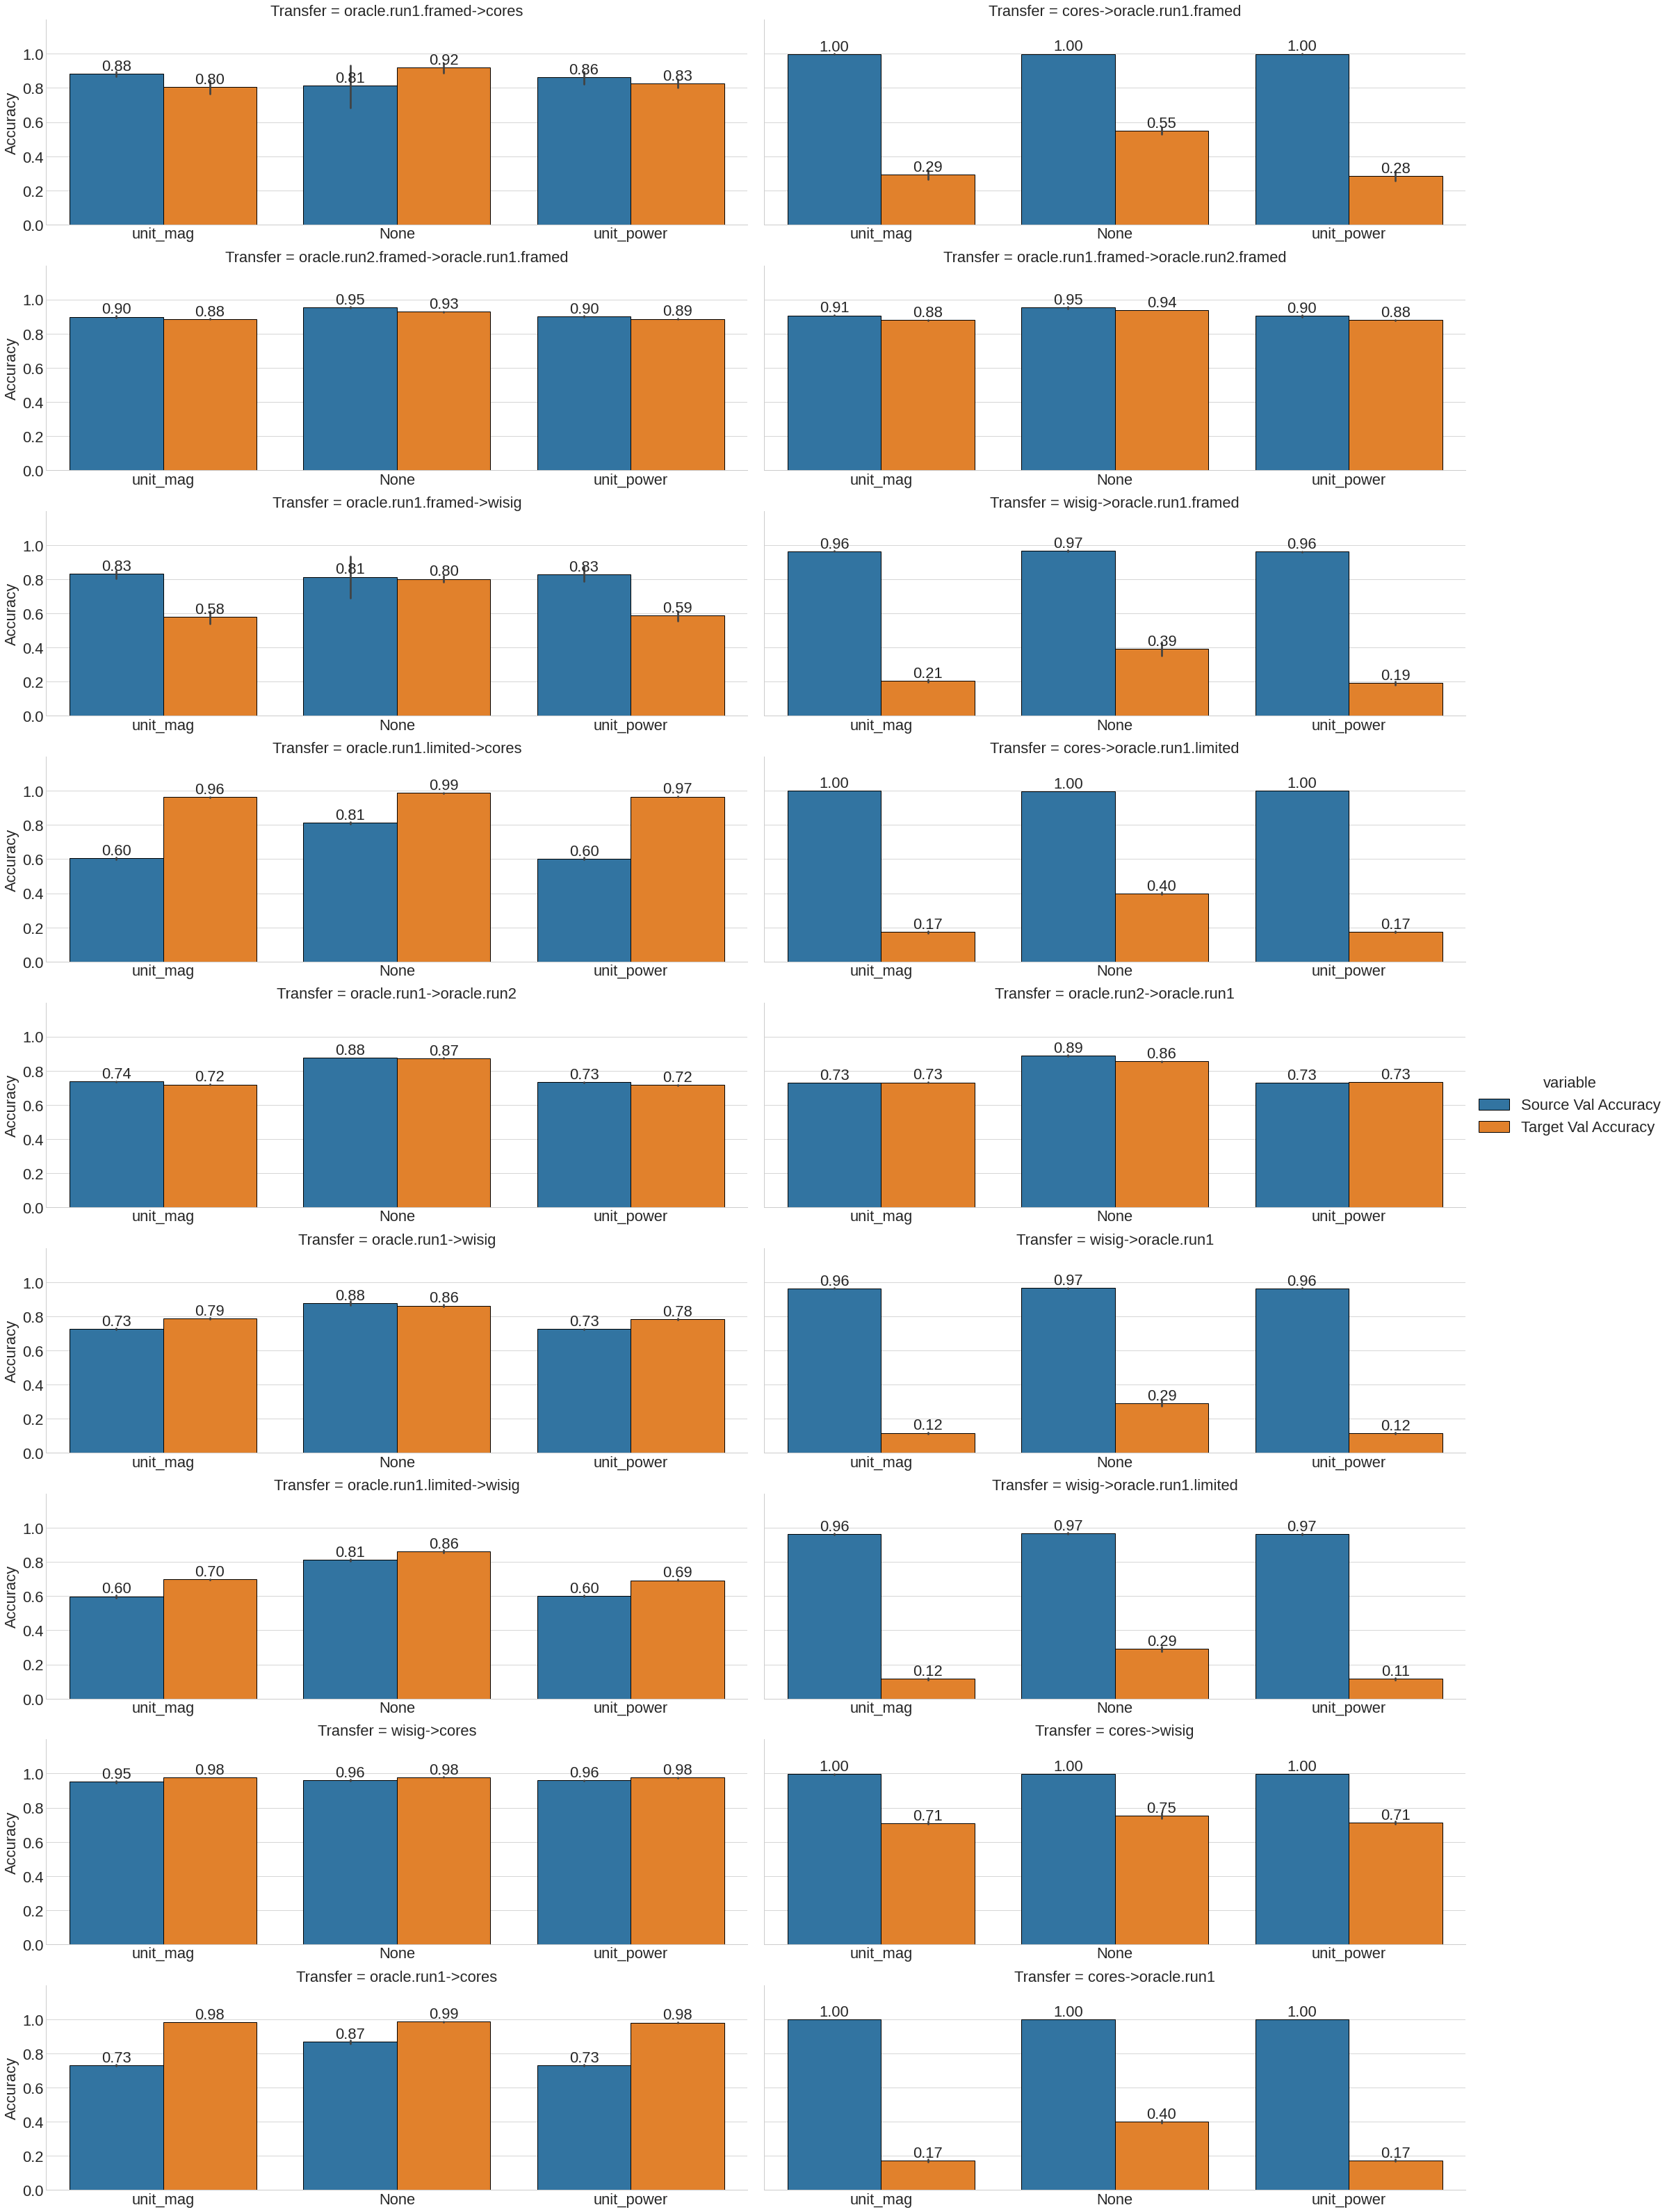

<Figure size 1080x3600 with 0 Axes>

In [461]:
p = get_tl_1()

m = pd.melt(p, 
        id_vars=["Transfer", "x_transform"],
        value_name="Accuracy",
        value_vars=[
            "Source Val Accuracy",
            "Target Val Accuracy",
        ])
matplotlib.rcParams.update({'font.size': 22})
plt.style.use('seaborn-whitegrid')

fg = sb.catplot(x='x_transform', col="Transfer", y='Accuracy', hue='variable', 
                        data=m, kind='bar', height=5, aspect=3, col_wrap=2, edgecolor = "black")
fg.set_xlabels('')
plt.figure(figsize=(15,50))

# iterate through axes
for ax in fg.axes.ravel():
    
    ax.tick_params(labelbottom=True)
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()):.2f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

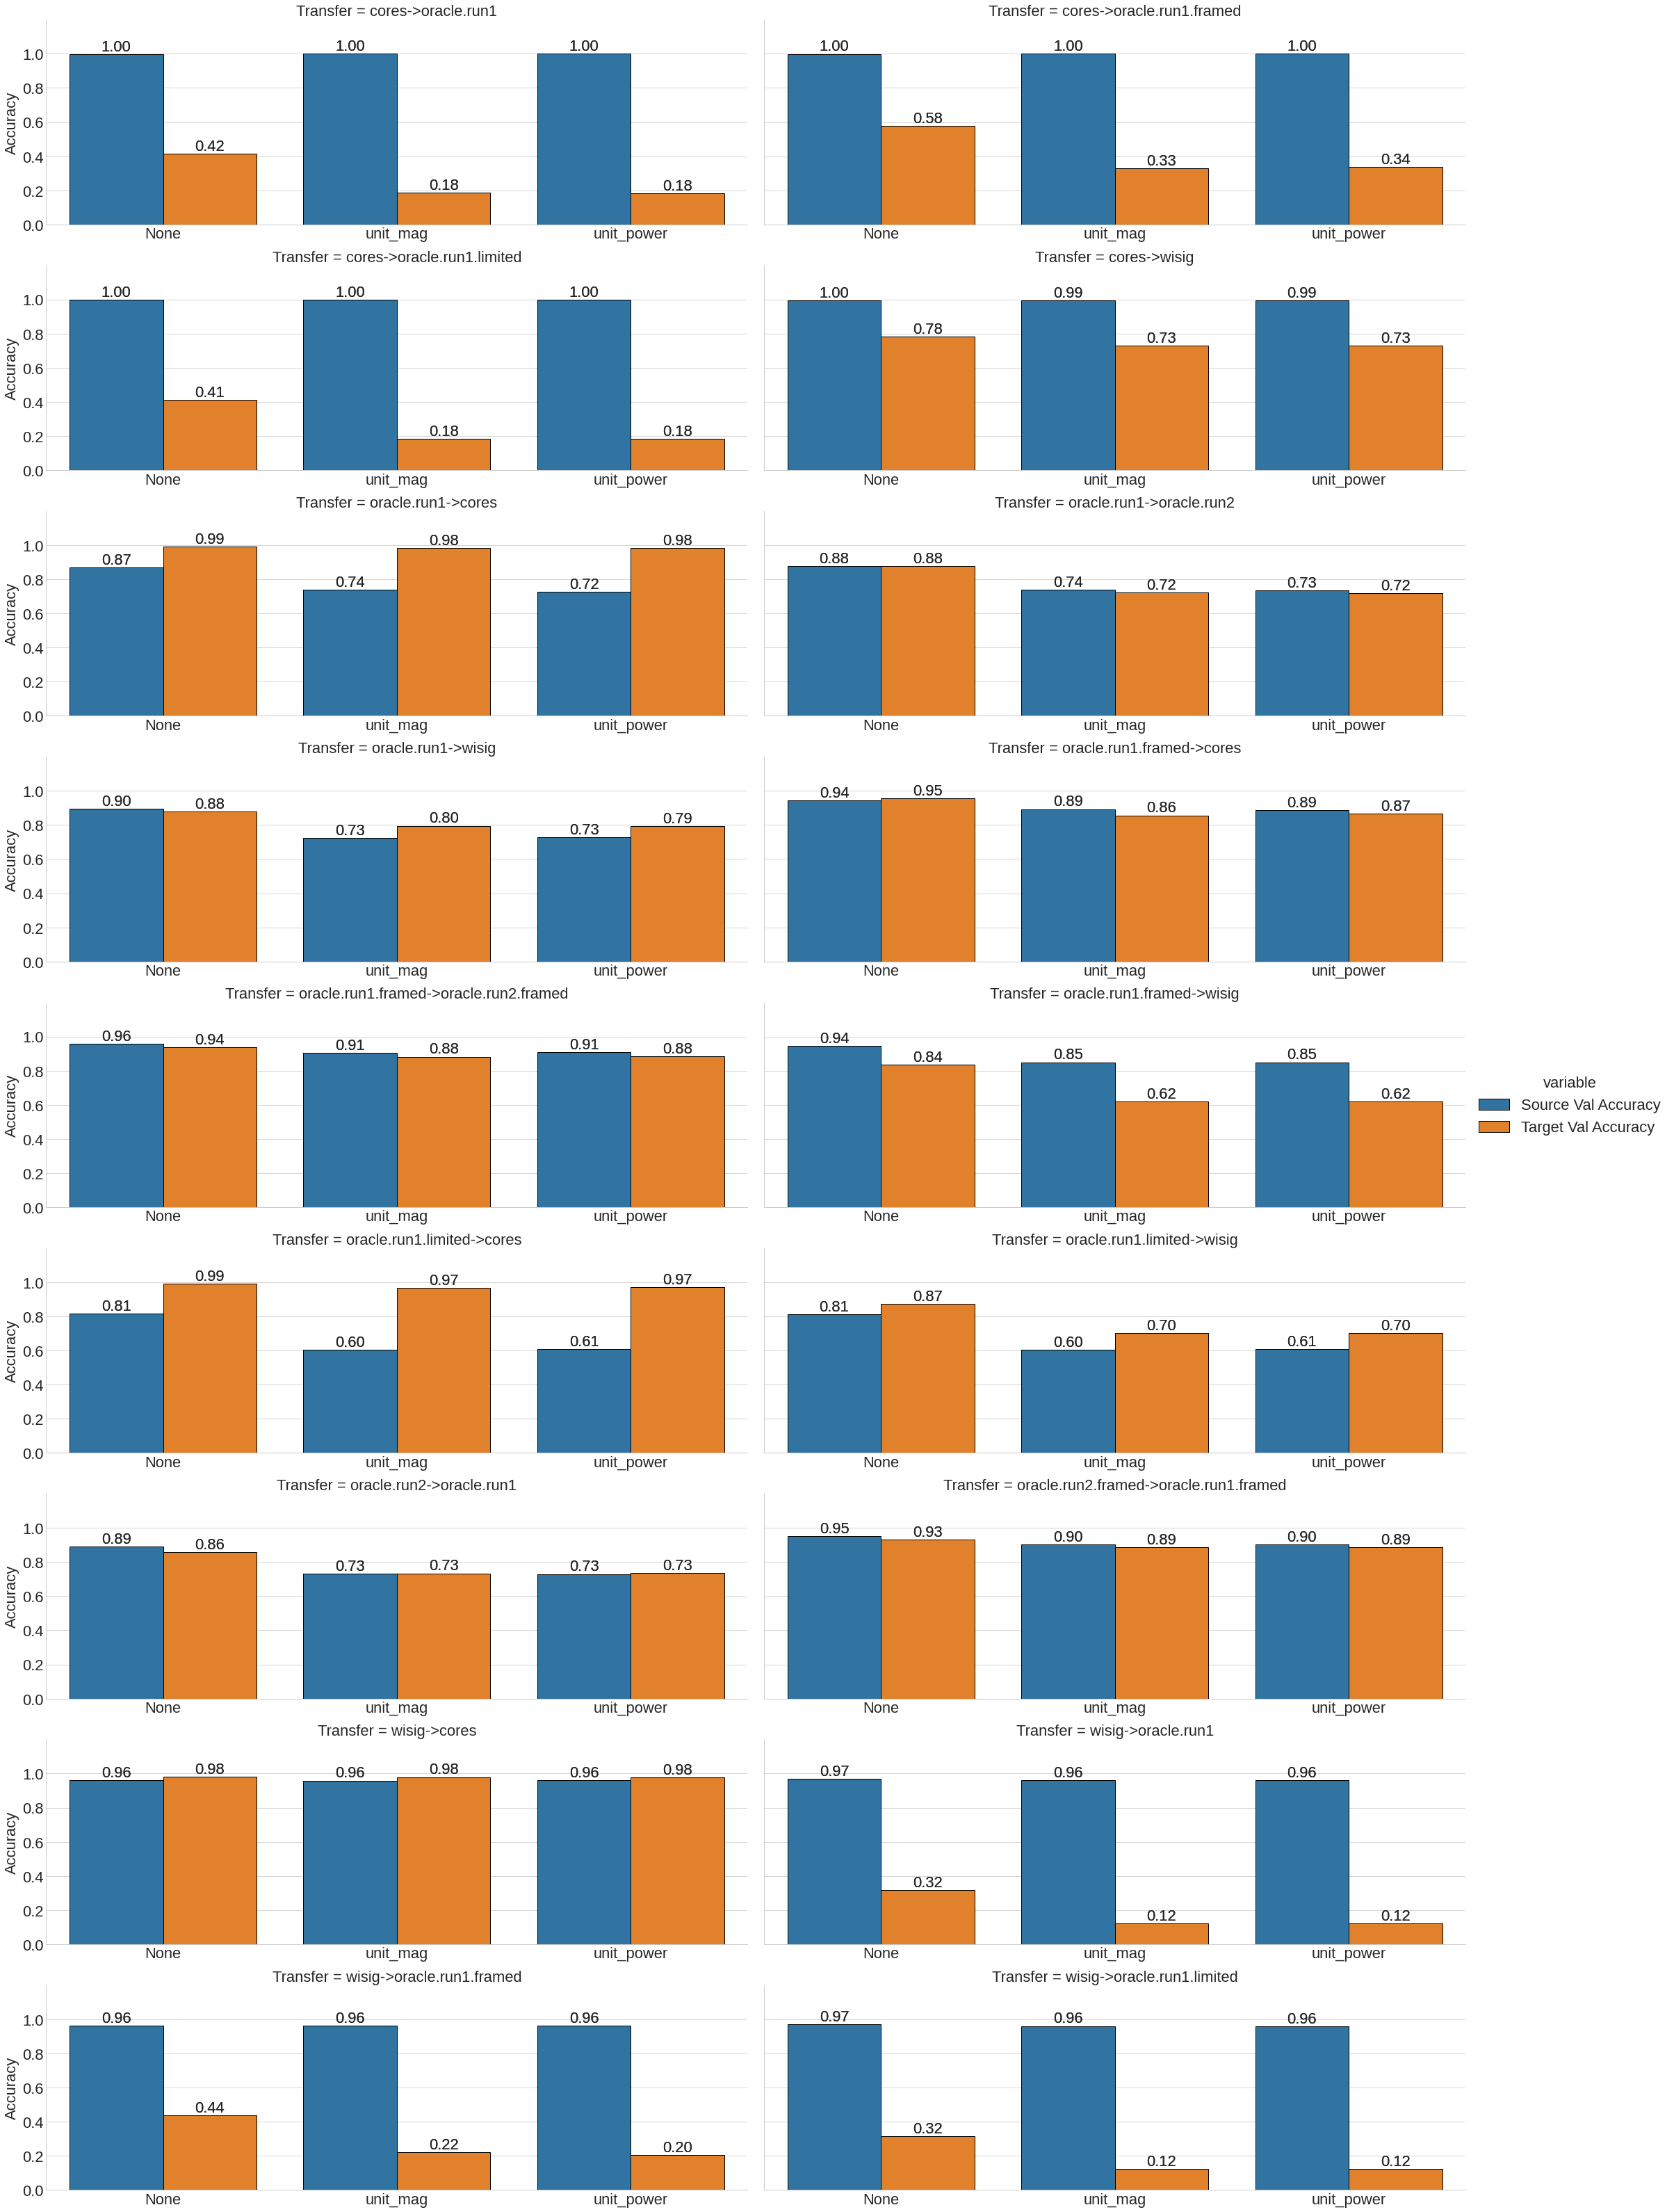

<Figure size 1080x3600 with 0 Axes>

In [462]:
i =get_tl_1_best()
m = pd.melt(i, 
        id_vars=["Transfer", "x_transform"],
        value_name="Accuracy",
        value_vars=[
            "Source Val Accuracy",
            "Target Val Accuracy",
        ])

fg = sb.catplot(x='x_transform', col="Transfer", y='Accuracy', hue='variable', 
                        data=m, kind='bar', height=5, aspect=3, col_wrap=2, edgecolor = "black")
fg.set_xlabels('')
plt.figure(figsize=(15,50))

set_nice_sb_style()
add_value_to_sb_bars(fg)
add_x_val_to_sb_bars(fg)


In [463]:
def get_tl_1_best():
    t = get_tl_1()

    idx = t.groupby(independent_vars)["Target Val Accuracy"].transform(max) == t["Target Val Accuracy"] # This will return _ALL_ rows with max in a group
    maxed = t[idx]
    maxed = maxed.groupby(independent_vars).first() # If there are multiple of max target val acc, we just drop the others
    maxed = maxed.reset_index()
    return maxed
    # return t[idx]
    # i = t.set_index(independent_vars)
    i[["Target Val Accuracy", "Source Val Accuracy"]] = t.groupby(independent_vars)[["Target Val Accuracy", "Source Val Accuracy"]].max()
    i = i[["Target Val Accuracy", "Source Val Accuracy"]]
    i = i.drop_duplicates()
    i = i.reset_index()
    return i

t = get_tl_1_best()
t = t.pivot(index=["Transfer"], columns=["x_transform"], values=["Source Val Accuracy", "Target Val Accuracy"])
print(t.columns)
t["Source Mag Delta"]   =    t[("Source Val Accuracy", "unit_mag")] - t[("Source Val Accuracy", "None")]
t["Source Power Delta"] =    t[("Source Val Accuracy", "unit_power")] - t[("Source Val Accuracy", "None")]
t["Target Mag Delta"] =    t[("Target Val Accuracy", "unit_mag")] - t[("Target Val Accuracy", "None")]
t["Target Power Delta"] =    t[("Target Val Accuracy", "unit_power")] - t[("Target Val Accuracy", "None")]
t = t.sort_values("Target Mag Delta")
t


MultiIndex([('Source Val Accuracy',       'None'),
            ('Source Val Accuracy',   'unit_mag'),
            ('Source Val Accuracy', 'unit_power'),
            ('Target Val Accuracy',       'None'),
            ('Target Val Accuracy',   'unit_mag'),
            ('Target Val Accuracy', 'unit_power')],
           names=[None, 'x_transform'])


Source Val Accuracy            \
x_transform                                           None  unit_mag   
Transfer                                                               
cores->oracle.run1.framed                         0.998965  0.999250   
cores->oracle.run1                                0.998500  0.999287   
cores->oracle.run1.limited                        0.998500  0.999287   
oracle.run1.framed->wisig                         0.943229  0.849349   
wisig->oracle.run1.framed                         0.960830  0.961036   
wisig->oracle.run1                                0.968552  0.959873   
wisig->oracle.run1.limited                        0.968552  0.959873   
oracle.run1.limited->wisig                        0.812598  0.603451   
oracle.run1->oracle.run2                          0.875866  0.739336   
oracle.run2->oracle.run1                          0.891563  0.730540   
oracle.run1.framed->cores                         0.943229  0.892643   
oracle.run1->wisig                                0.895553  0.725195   
oracle.run1.framed->oracle.run2.framed            0.958105  0.905762   
cores->wisig                                      0.995330  0.994432   
oracle.run2.framed->oracle.run1.framed            0.951758  0.903027   
oracle.run1.limited->cores                        0.814193  0.603451   
oracle.run1->cores                                0.869017  0.738600   
wisig->cores                                      0.961140  0.958917   

                                                  Target Val Accuracy  \
x_transform                            unit_power                None   
Transfer                                                                
cores->oracle.run1.framed                0.999536            0.579199   
cores->oracle.run1                       0.999215            0.415306   
cores->oracle.run1.limited               0.999215            0.410872   
oracle.run1.framed->wisig                0.849349            0.835806   
wisig->oracle.run1.framed                0.963183            0.435579   
wisig->oracle.run1                       0.959609            0.317826   
wisig->oracle.run1.limited               0.959609            0.316016   
oracle.run1.limited->wisig               0.608952            0.873910   
oracle.run1->oracle.run2                 0.733587            0.875788   
oracle.run2->oracle.run1                 0.729681            0.857194   
oracle.run1.framed->cores                0.888346            0.954536   
oracle.run1->wisig                       0.728398            0.878402   
oracle.run1.framed->oracle.run2.framed   0.909277            0.938053   
cores->wisig                             0.994432            0.783347   
oracle.run2.framed->oracle.run1.framed   0.902279            0.930924   
oracle.run1.limited->cores               0.609310            0.990990   
oracle.run1->cores                       0.724863            0.990500   
wisig->cores                             0.958984            0.980963   

                                                            Source Mag Delta  \
x_transform                             unit_mag unit_power                    
Transfer                                                                       
cores->oracle.run1.framed               0.327897   0.336426         0.000285   
cores->oracle.run1                      0.184824   0.183698         0.000787   
cores->oracle.run1.limited              0.184733   0.184310         0.000787   
oracle.run1.framed->wisig               0.618936   0.617319        -0.093880   
wisig->oracle.run1.framed               0.221875   0.203353         0.000206   
wisig->oracle.run1                      0.123516   0.121693        -0.008679   
wisig->oracle.run1.limited              0.124642   0.123893        -0.008679   
oracle.run1.limited->wisig              0.701030   0.703158        -0.209147   
oracle.run1->oracle.run2                0.721283   0.717682        -0.136530   
oracle.run2->oracle.run1        

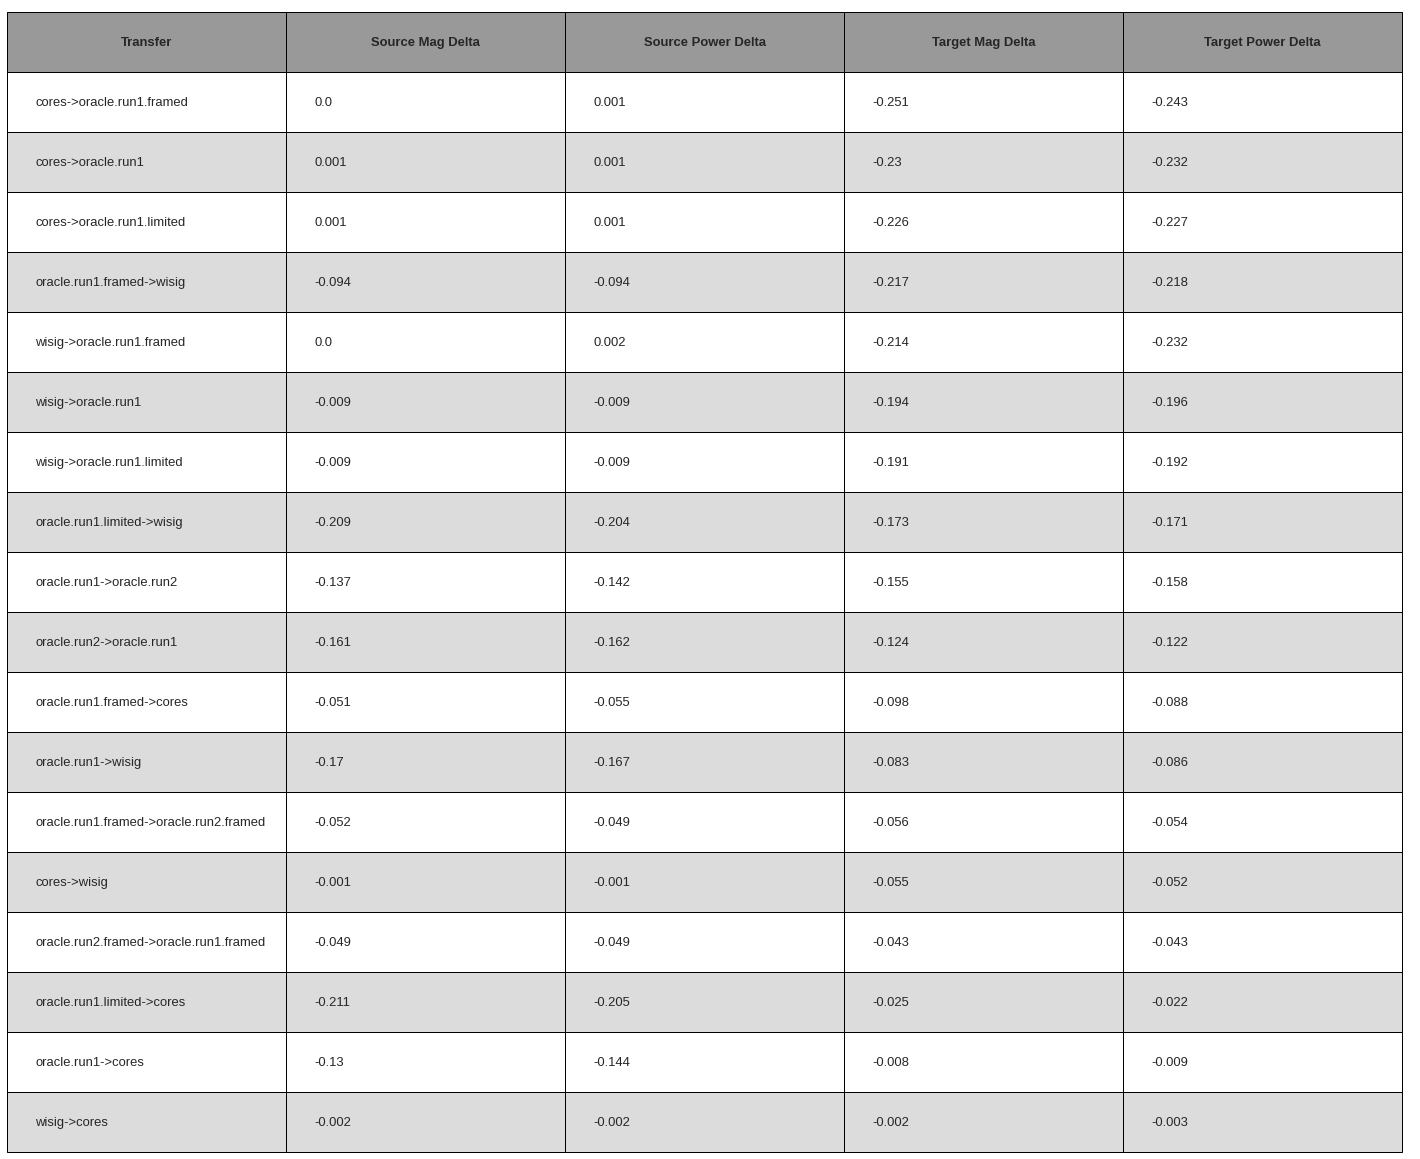

In [464]:
import copy
import numpy as np
tt = copy.deepcopy(t)
tt.columns = t.columns.droplevel(1)
tt = tt[["Source Mag Delta", "Source Power Delta", "Target Mag Delta", "Target Power Delta"]]
tt = tt.reset_index()
tt = tt.round(3)

fig, ax = plt.subplots(1)
fig.set_size_inches(10,5)

# For the alternating row colors
z = np.zeros([len(tt.index), len(tt.columns)], dtype=object)
z[1::2] = "#DCDCDC"
z[0::2] = "white"

tab = ax.table(
    cellText=tt.values, colLabels=tt.columns, 
    loc='best', cellLoc='left', 
    colColours=[(.6, .6, .6)] * 10, cellColours=z,
    colWidths=[0.1]*5
)
# tab = ax.table(cellText=tt.values, colLabels=tt.columns, )
ax.set_axis_off()
tab.auto_set_font_size(True)
tab.set_fontsize(20)
# tab.scale(1.5, 2)
tab.scale(5, 5)
# fig.set_tight_layout(True)

from matplotlib.font_manager import FontProperties

for (row, col), cell in tab.get_celld().items():
  if (row == 0) or (col == -1):
    cell.set_text_props(fontproperties=FontProperties(weight='bold'))

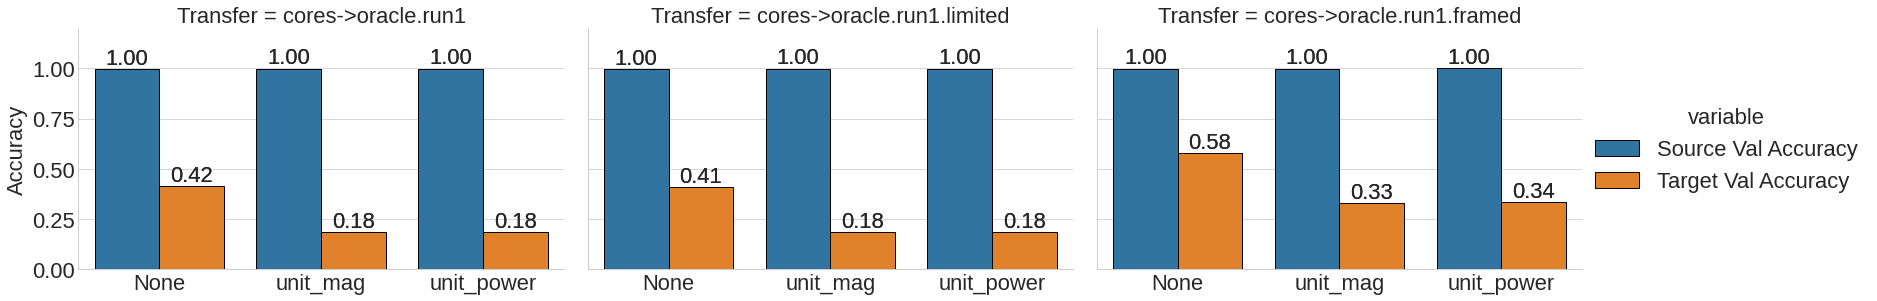

<Figure size 1080x3600 with 0 Axes>

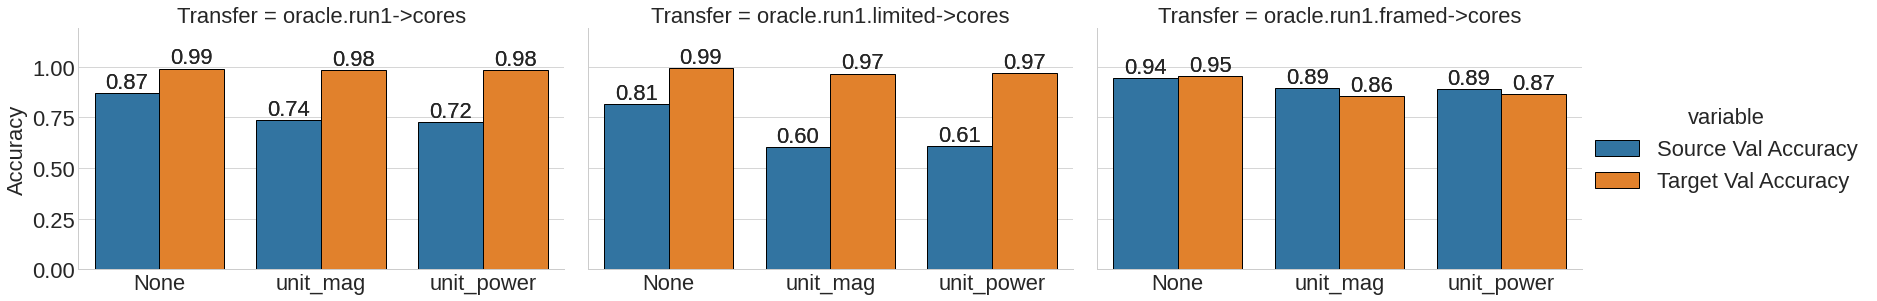

In [472]:
t = get_tl_1_best()
t = t[(t["Transfer"] == "cores->oracle.run1") | (t["Transfer"] == "cores->oracle.run1.limited") | (t["Transfer"] == "cores->oracle.run1.framed")]
m = pd.melt(t, 
        id_vars=["Transfer", "x_transform"],
        value_name="Accuracy",
        value_vars=[
            "Source Val Accuracy",
            "Target Val Accuracy",
        ])

fg = sb.catplot(x='x_transform', col="Transfer", y='Accuracy', hue='variable', 
                        data=m, kind='bar', height=5, aspect=1.5, col_wrap=3, edgecolor = "black",
                        col_order=["cores->oracle.run1", "cores->oracle.run1.limited", "cores->oracle.run1.framed"]
                )
fg.set_xlabels('')
plt.figure(figsize=(15,50))

set_nice_sb_style()
add_value_to_sb_bars(fg)
add_x_val_to_sb_bars(fg)


####


t = get_tl_1_best()
t = t[(t["Transfer"] == "oracle.run1->cores") | (t["Transfer"] == "oracle.run1.limited->cores") | (t["Transfer"] == "oracle.run1.framed->cores")]
m = pd.melt(t, 
        id_vars=["Transfer", "x_transform"],
        value_name="Accuracy",
        value_vars=[
            "Source Val Accuracy",
            "Target Val Accuracy",
        ])

fg = sb.catplot(x='x_transform', col="Transfer", y='Accuracy', hue='variable', 
                        data=m, kind='bar', height=5, aspect=1.5, col_wrap=3, edgecolor = "black",
                        col_order=["oracle.run1->cores","oracle.run1.limited->cores","oracle.run1.framed->cores"]
                )
fg.set_xlabels('')
# plt.figure(figsize=(15,50))

set_nice_sb_style()
add_value_to_sb_bars(fg)
add_x_val_to_sb_bars(fg)

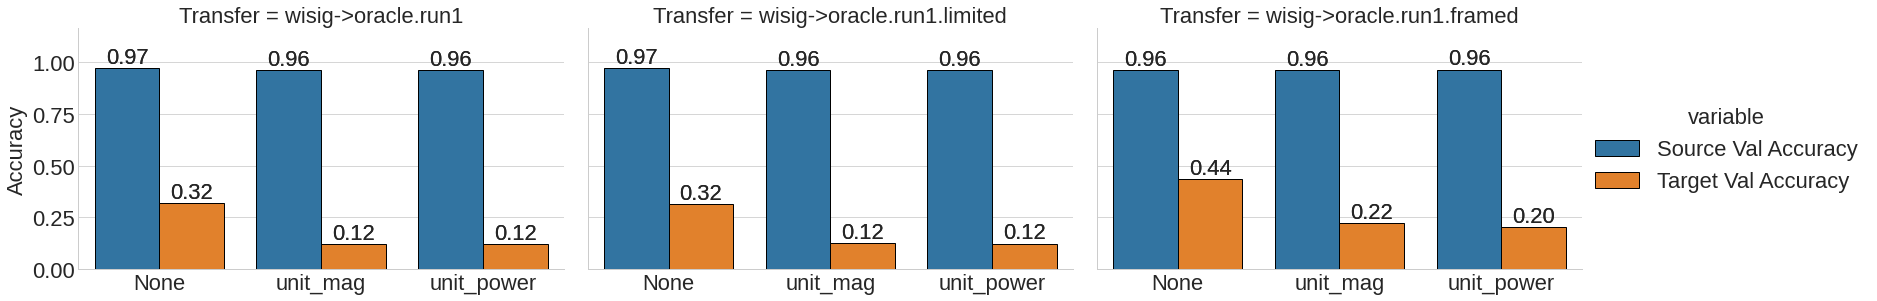

<Figure size 1080x3600 with 0 Axes>

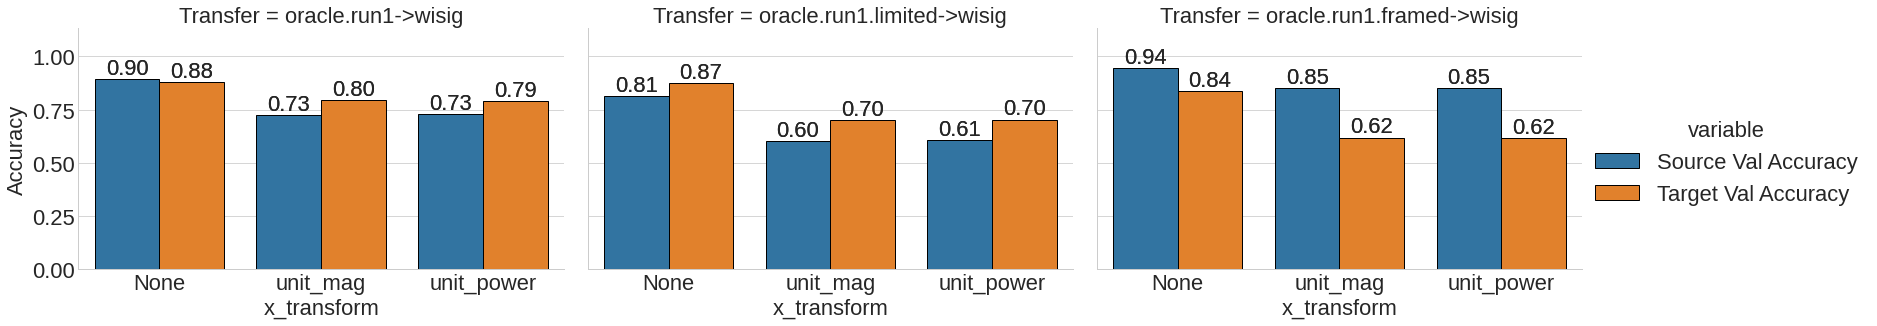

In [470]:
t = get_tl_1_best()
t = t[(t["Transfer"] == "wisig->oracle.run1") | (t["Transfer"] == "wisig->oracle.run1.limited") | (t["Transfer"] == "wisig->oracle.run1.framed")]
m = pd.melt(t, 
        id_vars=["Transfer", "x_transform"],
        value_name="Accuracy",
        value_vars=[
            "Source Val Accuracy",
            "Target Val Accuracy",
        ])

fg = sb.catplot(x='x_transform', col="Transfer", y='Accuracy', hue='variable', 
                        data=m, kind='bar', height=5, aspect=1.5, col_wrap=3, edgecolor = "black",
                        col_order=["wisig->oracle.run1", "wisig->oracle.run1.limited", "wisig->oracle.run1.framed"]
                )
fg.set_xlabels('')
plt.figure(figsize=(15,50))

set_nice_sb_style()
add_value_to_sb_bars(fg)
add_x_val_to_sb_bars(fg)


####


t = get_tl_1_best()
t = t[(t["Transfer"] == "oracle.run1->wisig") | (t["Transfer"] == "oracle.run1.limited->wisig") | (t["Transfer"] == "oracle.run1.framed->wisig")]
m = pd.melt(t, 
        id_vars=["Transfer", "x_transform"],
        value_name="Accuracy",
        value_vars=[
            "Source Val Accuracy",
            "Target Val Accuracy",
        ])

fg = sb.catplot(x='x_transform', col="Transfer", y='Accuracy', hue='variable', 
                        data=m, kind='bar', height=5, aspect=1.5, col_wrap=3, edgecolor = "black",
                        col_order=["oracle.run1->wisig","oracle.run1.limited->wisig","oracle.run1.framed->wisig"]
                )


set_nice_sb_style()
add_value_to_sb_bars(fg)
add_x_val_to_sb_bars(fg)